# Binder Classification — Physicochemical Feature Analysis

This notebook isolates the physicochemical‑descriptor workflow from the original EDA.
We focus on preparing interpretable molecular descriptors, training the random forest
classifier, and reviewing performance metrics without any SMILES fingerprint steps.

## 1) Setup & Imports

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, precision_recall_curve, roc_curve,
                             auc, matthews_corrcoef, balanced_accuracy_score, ConfusionMatrixDisplay)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Plotting defaults: single-plot figures, no seaborn, no custom colors/styles
plt.rcParams.update({"figure.figsize": (8,5), "axes.grid": True})


## 2) Load Dataset

In [3]:

# Update path if needed
DATA_PATH = "ic50.tsv"

df = pd.read_csv(DATA_PATH, sep="\t", low_memory=False)
print("Shape:", df.shape)
df.head()


Shape: (2863, 48)


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value,Value
0,CHEMBL2164249,NaN,NaN,161.16,0.0,-0.13,29,CN(C)OC(=O)CCC(=O)O,IC50,'=',...,CHEMBL2163321,1,Scientific Literature,J Med Chem,2012,NaN,NaN,NaN,NaN,6.3
1,CHEMBL222824,SUCCINYLACETONE,NaN,158.15,0.0,0.40,28,CC(=O)CC(=O)CCC(=O)O,IC50,'>',...,CHEMBL2163321,1,Scientific Literature,J Med Chem,2012,NaN,NaN,NaN,NaN,100.0
2,CHEMBL5901874,NaN,NaN,447.47,0.0,4.66,BDBM373543,Cc1cccc(C)c1Oc1cc2c(N3CCCC3)nc(-n3cc(C(=O)O)cn...,IC50,'=',...,CHEMBL5728393,37,BindingDB Patent Bioactivity Data,NaN,2021,NaN,NaN,NaN,NaN,39.8
3,CHEMBL1215451,NaN,NaN,296.80,0.0,1.19,6,CN(C)CCCCCCC(=O)N(O)CCC(=O)O.Cl,IC50,NaN,...,CHEMBL1212921,1,Scientific Literature,J Med Chem,2010,CHEMBL3308860,NaN,NaN,NaN,NaN
4,CHEMBL218493,NaN,NaN,289.29,0.0,3.06,13,N#Cc1cccc(NC(=O)c2ccc3cccnc3c2O)c1,IC50,'=',...,CHEMBL1139686,1,Scientific Literature,Bioorg Med Chem Lett,2006,NaN,NaN,NaN,NaN,6.1


## 3) Create Target & Show Class Distribution

**Definition:**  
- Binder = `IC50 (Standard Value) ≤ 2000 nM`  
- Non‑binder = `IC50 > 2000 nM`

> **Important:** We will **exclude** `Standard Value` (IC50) and `pChEMBL Value` from features to avoid label leakage.

Class counts (0=Non-binder, 1=Binder):
 Binder
0    1005
1    1849
Binder ratio: 64.8%


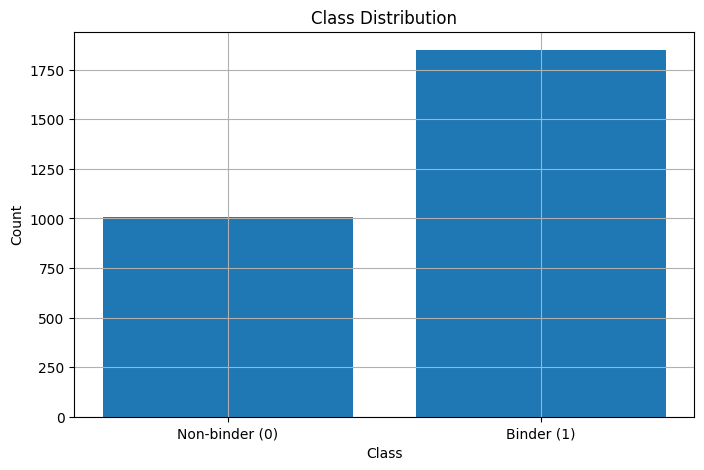

In [4]:
# Convert key columns
df["Standard Value"] = pd.to_numeric(df.get("Standard Value"), errors="coerce")
df["pChEMBL Value"] = pd.to_numeric(df.get("pChEMBL Value"), errors="coerce")

# Keep rows with an IC50 measurement so the label is defined
df = df.dropna(subset=["Standard Value"])

# Binary label
df["Binder"] = (df["Standard Value"] <= 2000).astype(int)

# Class counts
class_counts = df["Binder"].value_counts().sort_index()
binder_ratio = class_counts.get(1, 0) / class_counts.sum()

print("Class counts (0=Non-binder, 1=Binder):\n", class_counts.to_string())
print(f"Binder ratio: {binder_ratio:.1%}")

# Bar plot: class distribution
plt.figure()
plt.bar(["Non-binder (0)", "Binder (1)"], [class_counts.get(0,0), class_counts.get(1,0)])
plt.title("Class Distribution")
plt.ylabel("Count")
plt.xlabel("Class")
plt.show()


## 4) Feature Set (No Leakage) & Pre‑processing

We **exclude** `Standard Value` and `pChEMBL Value` from features.  
We keep **physicochemical** & **efficiency** descriptors that are commonly available before biological testing.


In [5]:

candidate_features = [
    "Molecular Weight", "AlogP", "#RO5 Violations",
    "Ligand Efficiency BEI", "Ligand Efficiency LE",
    "Ligand Efficiency LLE", "Ligand Efficiency SEI"
]

# Convert numerics & keep those with sufficient non-missing coverage
for col in candidate_features:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

features = [c for c in candidate_features if c in df.columns and df[c].notna().mean() > 0.4]
print("Using features:", features)

# Impute numeric with mean (simple baseline)
X = df[features].copy()
X = X.fillna(X.mean())

y = df["Binder"].copy()

# Scale numeric features (benefits distance-based/linear models; neutral for trees)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Stratified split to preserve imbalance ratio
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

X_train.shape, X_test.shape


Using features: ['Molecular Weight', 'AlogP', '#RO5 Violations', 'Ligand Efficiency BEI', 'Ligand Efficiency LE', 'Ligand Efficiency LLE', 'Ligand Efficiency SEI']


((2140, 7), (714, 7))

## 5) Model — Random Forest

In [6]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Predictions and probabilities
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

## 6) Evaluation Metrics

**Key metrics for model evaluation:**
- **Accuracy** — percentage of correct predictions
- **Precision** — of predicted binders, how many are true binders (guards against false positives)
- **Recall** — of true binders, how many did we catch (guards against false negatives)
- **F1-score** — harmonic mean of precision & recall
- **PR-AUC** — area under Precision–Recall curve; robust metric for classification
- **ROC-AUC** — area under ROC curve; measures model discrimination ability
- **MCC** — Matthews Correlation Coefficient; single robust metric for any class distribution

In [7]:

from sklearn.metrics import classification_report

# Core metrics
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
mcc = matthews_corrcoef(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred, target_names=["Non-binder", "Binder"]))
print(f"PR-AUC: {pr_auc:.3f}")
print(f"Balanced Accuracy: {bal_acc:.3f}")
print(f"MCC: {mcc:.3f}")

# Optional ROC-AUC (can look optimistic with heavy skew)
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC (secondary): {roc_auc:.3f}")


              precision    recall  f1-score   support

  Non-binder       0.97      0.97      0.97       251
      Binder       0.98      0.98      0.98       463

    accuracy                           0.98       714
   macro avg       0.98      0.98      0.98       714
weighted avg       0.98      0.98      0.98       714

PR-AUC: 0.999
Balanced Accuracy: 0.977
MCC: 0.954
ROC-AUC (secondary): 0.999


### Precision–Recall Curve

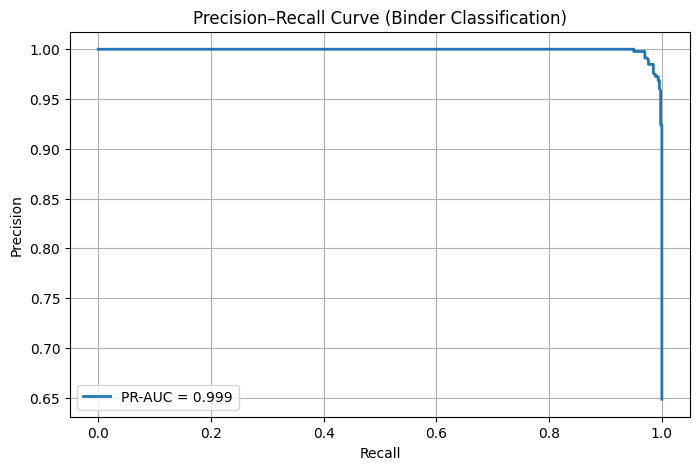

In [8]:

plt.figure()
plt.plot(recall, precision, linewidth=2, label=f"PR-AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Binder Classification)")
plt.legend()
plt.show()


### Confusion Matrix

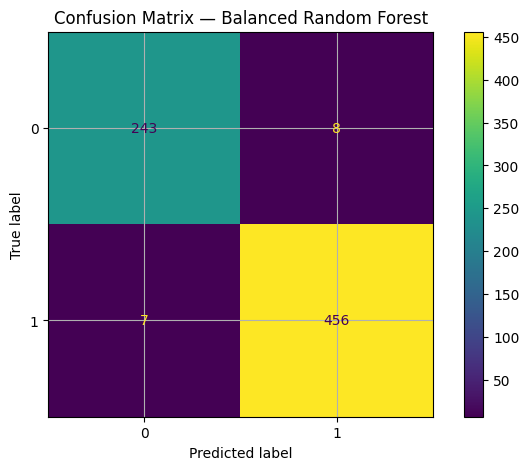

In [9]:

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix — Balanced Random Forest")
plt.show()


## 7) Feature Importance (No Leakage)

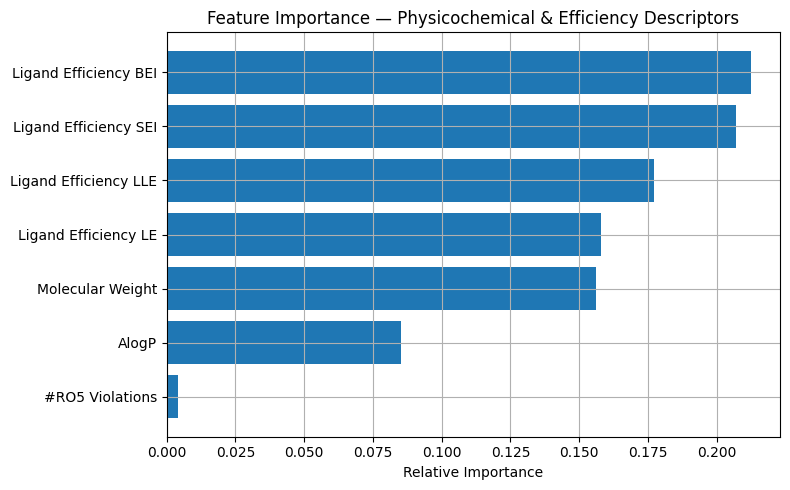

,Feature,Importance
0,Ligand Efficiency BEI,0.212437
1,Ligand Efficiency SEI,0.207017
2,Ligand Efficiency LLE,0.177174
3,Ligand Efficiency LE,0.157874
4,Molecular Weight,0.156265
5,AlogP,0.085098
6,#RO5 Violations,0.004135


In [10]:

importances = rf.feature_importances_
order = np.argsort(importances)[::-1]

plt.figure()
plt.barh(np.array(features)[order], importances[order])
plt.gca().invert_yaxis()
plt.xlabel("Relative Importance")
plt.title("Feature Importance — Physicochemical & Efficiency Descriptors")
plt.tight_layout()
plt.show()

pd.DataFrame({"Feature": np.array(features)[order], "Importance": importances[order]})


## 8) Takeaways

- With the **2000 nM threshold**, we have a reasonably balanced dataset (~65% binders, ~35% non-binders)
- Random Forest with physicochemical features achieves strong performance
- **Most predictive** properties include **LLE**, **Molecular Weight**, and **AlogP**
- These results suggest **efficient, drug-like** molecules are more likely to be binders